In [11]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#INPUTS
col_sect = 'RECT'   # Column Section 'RECT' or 'CIRC'
col_type = 'BRACED' # 'BRACED' or ' UNBRACED' (defaults to BRACED)

fc = 65             # [MPa] Concrete Strength

b = 900             # [mm] Breadth
h = 1100            # [mm] Depth

dbar = 32           # [mm] Bar Diameter
xbar = 4            # number of bars x direciton 
ybar = 6            # number of bars y direction

l =  3100           # [mm] Height of The column
ke2 = 1.0           # k factor for 'b' Direction
ke3 = 1.0           # k factor for 'h' direciton

cover = 40          # [mm] Concrete Cover

fy = 500            # [MPa] Steel Yield Strength

tie_db = 0          # [mm] Tie Bar Diameter (USER)
tie_spc = 0         # [mm] Tie Bar Spacing (USER)


In [13]:
def Min_TieSize(db):
    if db <= 20:
        Min_TieSize = 6
    elif db <= 24 or db <= 28:
        Min_TieSize = 10
    elif db <= 32 or db <= 36:
        Min_TieSize = 12
    else:  
        Min_TieSize = 16
    return Min_TieSize

tie = max(Min_TieSize(dbar), tie_db)        # Ensure Tie Size complie with Code

Max_TieSpacing = min(b, h, 15*dbar)
if fc > 50: 
    Max_TieSpacing = min(0.8*min(b, h), min(b,h), 300)

tie_spc = min(tie_spc, Max_TieSpacing)
if tie_spc <= 0: 
    tie_spc = Max_TieSpacing

tie, tie_spc


(12, 300)

In [14]:
# Slender Columns 
def col_Areas(sect, b, D):     # [mm^4] Second Moment of inertia
    match sect:
        case 'RECT':
            Ag = b * D                          # [mm²] Column Area
            Ig = b * D ** 3 / 12                # [mm^4] Second Moment of inertia
        case 'CIRC':
            Ag = math.pi * (D/2) **2
            Ig = math.pi /4 * (D/2) ** 4
    rgy = (Ig/ Ag) ** 0.5                       # [mm] Radius of Gyration
    return Ag, Ig, rgy

Col3 = col_Areas(col_sect, b, h)
Ag = Col3[0]
I3 = Col3[1]
r3 = Col3[2]

Col2 = col_Areas(col_sect, h, b)
I2 = Col2[1]
r2 = Col2[2]

# Moment Amplificaiton
M3min = h * 0.05                                 # [kNm] Minimum Moment (y-dirn)
M2min = b * 0.05                                 # [kNm] Minimum Moment (x-dirn)

In [15]:
# Effective Depth 
deff = h - cover - tie - dbar/2     # [mm] Distance from uppermost steel centre to bottom edge 

dox = b - cover - tie - dbar/2      # [mm] Distance from uppermost steel centre to bottom edge (X-Dirn) 
doy = h - cover - tie - dbar/2      # [mm] Distance from uppermost steel centre to bottom edge (y-Dirn)

#Bar Depth (ds)
dprime = cover + tie + dbar/2       # [mm] Distance from top of concrete to centre of reinforcement

deff,dprime

(1032.0, 68.0)

In [16]:
# Beta 1(stress Block Multiplier)
#Check Code
if fc <= 28:
    beta1 = 0.85
else:
    beta1 = max(0.85 - 0.05 * (fc - 28) / 7, 0.65)


# Stress Block Parameters
alpha1 = min(0.85, max(1 - 0.003 * fc, 0.72))

def alpha2(fc, section):
    alpha2 = max(0.85 - 0.0015 * fc, 0.67)
    
    if section == 'CIRC':
        alpha2 = alpha2 * 0.95

    return alpha2

gamma = max(0.97-0.0025 * fc, 0.67)

beta1, alpha1, alpha2(fc,col_sect), gamma

(0.65, 0.8049999999999999, 0.7525, 0.8075)

In [17]:
# Total Number of bars depending on Section 
match col_sect:
    case 'RECT':
        Bar_total = 2 * (xbar + ybar-2)
    case 'CIRC':
        Bar_total = ybar

Ast = (math.pi *dbar**2/4) * Bar_total      # [mm²] Steel area at tension side
Asc = Ast                                   # [mm²] Steel area at compression side

Ast, Asc

(12867.963509103793, 12867.963509103793)

In [18]:
#Stresss and strain 
Es = 200000         # [MPa] Steel Modulus (Constant)
ec = 0.003          # [MPa] Concrete Maximum strain (MPa)
ey = fy / Es        # Steel strain at yield point

def stress_strain(c):
    es = ec * (deff -c)/c       # Steel strain at neutral axis
    fs = es * Es
    esprime = ec *(c-dprime)/c  # Steel strain at compression side
    fsprime = esprime * Es      #tensile stress at compression side 
    a = beta1* c                # Compressive stress block depth
    return a, es, fs, esprime, fsprime

In [19]:
# Strength reduction factor
def strength_factor():
    phi_factor = 0.65 + 0.25 * (es - ey)/(0.005-ey)
    if phi_factor >= 0.9:
        phi, classify = 0.9, 'Tension-controlled'
    elif phi_factor <= 0.65:
        phi, classify = 0.65, 'Compression-controlled'
    else:
        phi, classify = phi_factor, 'Transition'
    return phi, classify

In [20]:
# Forces & Moments 
def forces_moments():
    T = Ast * min(fy,fs) /1000                              # [kN] Tension force by steel at tension side
    Cc = 0.85* fc * a * b /1000                             # [kN] Compressive force by concrete
    Cs = Asc * (min(fy, fsprime) - (0.85*fc)) /1000         # [kN] Compressive force by steel at compression side

    Pn = Cc + Cs - T                                        # [kN] Nominal Axial load capacity 
    Pu = phi * Pn                                           # [kN] Ultimate axial load capacity

    #Solve for eccentricity by taking moment about T: 
    #Sum of moments at T : Pn ( ecc + h/2 - dprime) - Cc(deff - a/2) - Cs (deff - a/2) = 0
    ecc = (Cc*(deff - a/2) + Cs*(deff - dprime)) / Pn - (h/2 - dprime)
    Mn = Pn * ecc /1000                             # Nominal Moment Capacity
    Mu = phi * Mn                                   # Ultimate Moment Capacity

    return ecc, Pn, Pu, Mn, Mu

In [21]:
# Solve Axial load and moment at varying 'c' Values 

nom_load = []
ult_load = []
nom_moment = []
ult_moment = []
eccentricity = []
phi_factor = []

c_values = np.arange(1000, 50, -5)
for c in c_values:
    a, es, fs, esprime, fsprime = stress_strain(c)
    phi, classify = strength_factor()
    ecc, Pn, Pu, Mn, Mu = forces_moments()
    if ecc <= 1.5*h:
        nom_load.append(round(Pn))
        ult_load.append(round(Pu))
        nom_moment.append(round(Mn))
        ult_moment.append(round(Mu))
        eccentricity.append(round(ecc))
        phi_factor.append(round(phi,2))

# Save the above values in a dataframe and plot the values
dict = {'ecc(mm)': eccentricity, 'Pn(kN)': nom_load, 'Pu(kN)': ult_load, 'Mn(kN.m)': nom_moment, 'Mu(kN.m)': ult_moment, 'phi': phi_factor}
df = pd.DataFrame(dict)

#Print last 10 rows 
df.tail(10)

,ecc(mm),Pn(kN),Pu(kN),Mn(kN.m),Mu(kN.m),phi
160,-3898,-1442,-1298,5622,5060,0.9
161,-2878,-1880,-1692,5410,4869,0.9
162,-2207,-2349,-2114,5183,4665,0.9
163,-1730,-2853,-2568,4938,4444,0.9
164,-1374,-3401,-3061,4672,4204,0.9
165,-1095,-4000,-3600,4380,3942,0.9
166,-870,-4662,-4196,4058,3652,0.9
167,-685,-5400,-4860,3698,3328,0.9
168,-528,-6235,-5612,3291,2962,0.9
169,-393,-7192,-6473,2825,2542,0.9


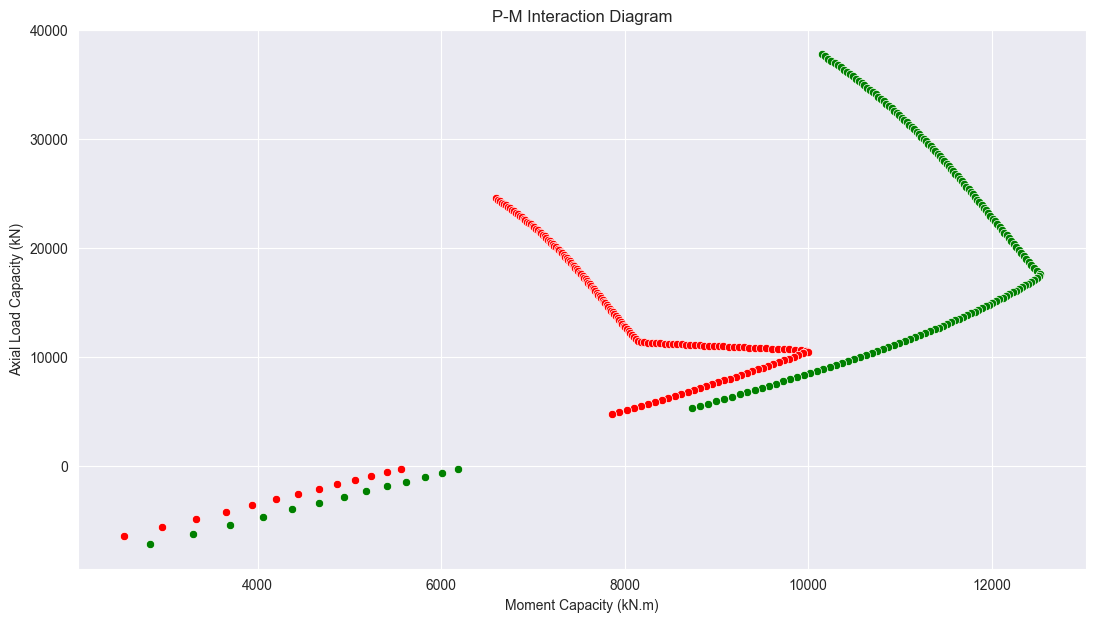

In [22]:
# Plots 

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(13,7))
ax = sns.scatterplot(x='Mn(kN.m)', y='Pn(kN)', data=df, color='g')
sns.scatterplot(x='Mu(kN.m)', y='Pu(kN)', data=df, color='r')
ax.set_xlabel('Moment Capacity (kN.m)')
ax.set_ylabel('Axial Load Capacity (kN)')
plt.title('P-M Interaction Diagram')
plt.show()


In [13]:
# Calulcate the maximum allowable axial load capacity

phi = 0.65
alpha = 0.85
Ag = b*h
As = math.pi * dbar**2 * ybar
Pmax = phi*alpha*0.85*fc*(Ag-As) + As*fy /1000

print('Maximum allowable concentric axial load: {} kN'.format(round(Pmax)))

Maximum allowable concentric axial load: 29640816 kN


https://app.calctree.com/3eae716e-d976-4518-aac7-7d20a0305663/Concrete-Column-Designer-to-AS3600-tqPtHqSo1x1i3vs1uv4N5r